# Step 1: Setup dan Konfigurasi

In [3]:
!pip install ultralytics

In [4]:
import os
import yaml
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
import pandas as pd

In [5]:
#Pengecekan file yaml

print("Mencari file data.yaml...")
yaml_files = glob.glob('/kaggle/input/**/*.yaml', recursive=True)

if yaml_files:
    data_yaml_path = yaml_files[0]
    print(f"File ditemukan: {data_yaml_path}")
    
    # Baca isinya
    with open(data_yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)
    
    print("\n--- ISI CONFIG DATASET ---")
    print(f"Jumlah Kelas (nc): {data_config.get('nc')}")
    print(f"Nama Kelas (names): {data_config.get('names')}")
    
    # Simpan nama kelas buat dipakai nanti
    class_names = data_config.get('names')
else:
    print("Gawat! File data.yaml tidak ketemu. Cek lagi datasetnya sudah di-attach belum?")

Mencari file data.yaml...
File ditemukan: /kaggle/input/rice-disease-detection-dataset-of-6000-images/data.yaml

--- ISI CONFIG DATASET ---
Jumlah Kelas (nc): 3
Nama Kelas (names): ['Bacteria_Leaf_Blight', 'Brown_Spot', 'Leaf_smut']


# Step 2: Exploratory Data Analysis

In [15]:
# Pastikan path ini mengarah ke folder yang membungkus 'images', 'labels', dan 'data.yaml'
dataset_root = '/kaggle/input/rice-disease-detection-dataset-of-6000-images'
# -------------------------

print(f"Memeriksa dataset di: {dataset_root}")

# Variable global
df = None
class_names = []

if os.path.exists(dataset_root):
    # Cek isi folder root dulu (Debug)
    print("Isi folder root:", os.listdir(dataset_root))

    # SETUP PATH LABEL (Sesuai Gambar)
    # Polanya: root -> labels -> train
    train_label_dir = os.path.join(dataset_root, 'labels', 'train2')
    
    # Cek apakah folder labels/train beneran ada
    if os.path.exists(train_label_dir):
        print(f"Folder Label ditemukan: {train_label_dir}")
        
        # AMBIL NAMA KELAS DARI YAML
        yaml_path = os.path.join(dataset_root, 'data.yaml')
        if os.path.exists(yaml_path):
            with open(yaml_path, 'r') as f:
                data = yaml.safe_load(f)
                if isinstance(data['names'], dict):
                    class_names = list(data['names'].values())
                else:
                    class_names = data['names']
                print(f"📋 Kelas: {class_names}")
        else:
            print("File data.yaml tidak ada, pakai default.")
            class_names = ['Brown Spot', 'Healthy', 'Hispa', 'Leaf Blast']

        # HITUNG FILE .TXT
        label_files = glob.glob(os.path.join(train_label_dir, '*.txt'))
        print(f"📊 Menghitung {len(label_files)} file label...")

        if label_files:
            class_counts = {name: 0 for name in class_names}

            for file in label_files:
                with open(file, 'r') as f:
                    lines = f.readlines()
                    for line in lines:
                        parts = line.strip().split()
                        if len(parts) >= 1:
                            class_id = int(parts[0])
                            if class_id < len(class_names):
                                name = class_names[class_id]
                                class_counts[name] += 1
            
            # Buat DataFrame
            df = pd.DataFrame(list(class_counts.items()), columns=['Penyakit', 'Jumlah'])
            df = df.sort_values(by='Jumlah', ascending=False)
            print("\nSELESAI! Hasil hitungan:")
            print(df)
        else:
            print("Folder ada, tapi kosong (tidak ada file .txt). Cek datasetnya.")

    else:
        print(f"Gagal menemukan folder: {train_label_dir}")
        print("Pastikan struktur folder datasetmu: labels/train/*.txt")

else:
    print(f"Path dataset utama salah! Path '{dataset_root}' tidak ditemukan.")

Memeriksa dataset di: /kaggle/input/rice-disease-detection-dataset-of-6000-images
Isi folder root: ['labels', 'data.yaml', 'images']
Folder Label ditemukan: /kaggle/input/rice-disease-detection-dataset-of-6000-images/labels/train2
📋 Kelas: ['Bacteria_Leaf_Blight', 'Brown_Spot', 'Leaf_smut']
📊 Menghitung 5372 file label...

SELESAI! Hasil hitungan:
               Penyakit  Jumlah
1            Brown_Spot   11010
2             Leaf_smut    5712
0  Bacteria_Leaf_Blight    2582


## a. Analisis Distribusi Kelas

/tmp/ipykernel_55/2194150356.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Jumlah', y='Penyakit', data=df, palette='viridis')


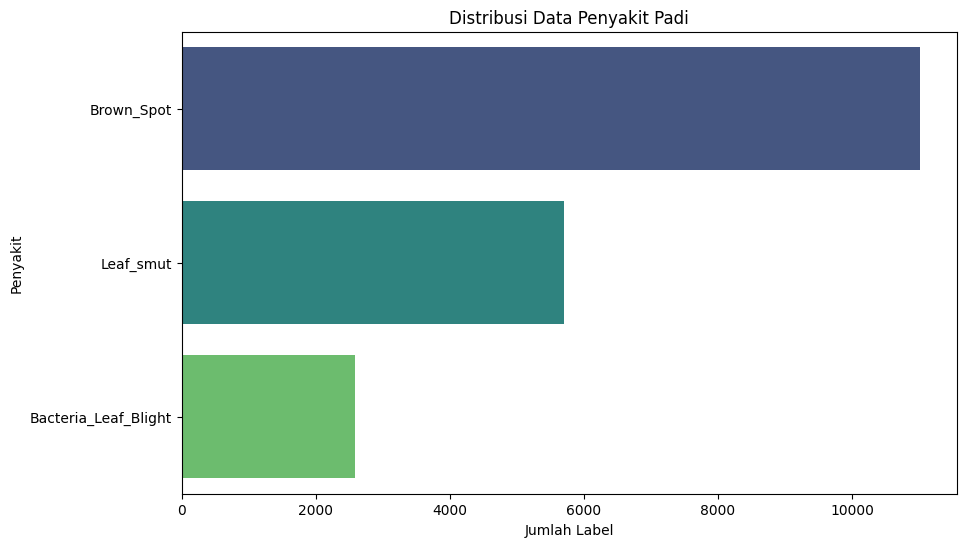

In [16]:
if 'df' in locals() and df is not None:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Jumlah', y='Penyakit', data=df, palette='viridis')
    plt.title("Distribusi Data Penyakit Padi")
    plt.xlabel("Jumlah Label")
    plt.show()
else:
    print("Jalankan Bagian 1 dulu ya!")

## b. Ground Truth

Memeriksa Gambar: brownspot_orig_018_jpg.rf.74b323c2e844ea06fbb322ca14a9e186.jpg
Memeriksa Label: brownspot_orig_018_jpg.rf.74b323c2e844ea06fbb322ca14a9e186.txt
Ditemukan 4 objek (bounding box).


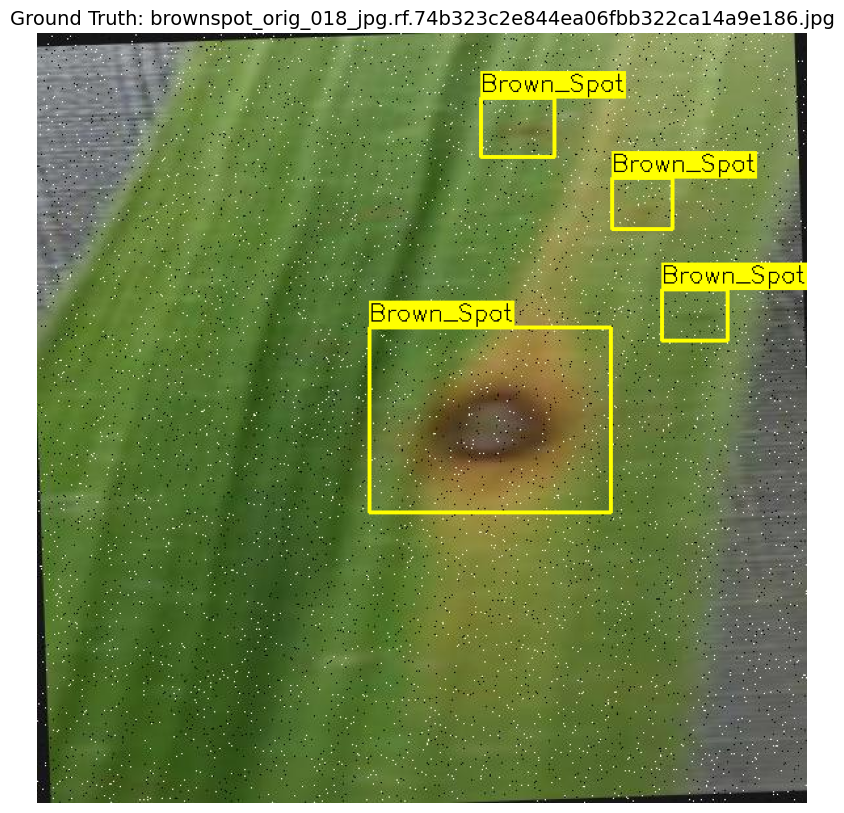

In [21]:
# Cek apakah class_names sudah ada dari langkah sebelumnya
# Kalau belum (misal session restart), kita definisikan ulang manual biar aman
if 'class_names' not in locals() or not class_names:
    print("class_names belum terdefinisi, menggunakan default.")
    class_names = ['Brown Spot', 'Healthy', 'Hispa', 'Leaf Blast']

# Setup Folder
train_images_dir = os.path.join(dataset_root, 'images', 'train')
train_labels_dir = os.path.join(dataset_root, 'labels', 'train2')

# Ambil 1 Gambar Acak
if os.path.exists(train_images_dir):
    all_images = os.listdir(train_images_dir)
    
    if all_images:
        random_filename = random.choice(all_images)
        img_path = os.path.join(train_images_dir, random_filename)
        
        # Cari file label pasangannya
        # Caranya: ganti ekstensi gambar (.jpg/.png) jadi .txt
        base_name = os.path.splitext(random_filename)[0]
        label_filename = base_name + '.txt'
        label_path = os.path.join(train_labels_dir, label_filename)
        
        print(f"Memeriksa Gambar: {random_filename}")
        print(f"Memeriksa Label: {label_filename}")

        # Baca Gambar
        image = cv2.imread(img_path)
        
        if image is None:
            print("Gagal membaca file gambar (corrupt atau path salah).")
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            h, w, _ = image.shape

            # Baca Label & Gambar Kotak
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    lines = f.readlines()
                    box_count = 0
                    for line in lines:
                        parts = line.strip().split()
                        if len(parts) >= 5:
                            cls_id = int(parts[0])
                            x_c, y_c, bw, bh = map(float, parts[1:])
                            
                            # Konversi YOLO (0-1) ke Pixel (x, y)
                            x1 = int((x_c - bw/2) * w)
                            y1 = int((y_c - bh/2) * h)
                            x2 = int((x_c + bw/2) * w)
                            y2 = int((y_c + bh/2) * h)
                            
                            # Gambar Kotak (Warna Kuning)
                            color = (255, 255, 0) 
                            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
                            
                            # Tulis Nama Kelas
                            if cls_id < len(class_names):
                                label_text = class_names[cls_id]
                            else:
                                label_text = f"Class {cls_id}"
                            
                            # Tambah background text biar kebaca
                            (text_w, text_h), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
                            cv2.rectangle(image, (x1, y1 - 20), (x1 + text_w, y1), color, -1)
                            cv2.putText(image, label_text, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)
                            
                            box_count += 1
                    
                    print(f"Ditemukan {box_count} objek (bounding box).")
            else:
                print("File label .txt TIDAK DITEMUKAN untuk gambar ini (Mungkin kelas Healthy/Background?)")

            # Tampilkan Plot
            plt.figure(figsize=(10, 10))
            plt.imshow(image)
            plt.axis('off')
            plt.title(f"Ground Truth: {random_filename}", fontsize=14)
            plt.show()
    else:
        print("Folder images/train kosong!")
else:
    print(f"Folder tidak ditemukan: {train_images_dir}")

# Step 3: Training Model (YOLOV8 Nano)

In [ ]:
import os
import shutil
import yaml
from ultralytics import YOLO

# --- 1. BERSIH-BERSIH DULU ---
# Kita hapus folder lama biar bersih total
work_dir = '/kaggle/working/dataset_final_fix'
if os.path.exists(work_dir):
    shutil.rmtree(work_dir)

# Bikin struktur folder baru
os.makedirs(f'{work_dir}/images/train', exist_ok=True)
os.makedirs(f'{work_dir}/images/val', exist_ok=True)
os.makedirs(f'{work_dir}/images/test', exist_ok=True)
os.makedirs(f'{work_dir}/labels/train', exist_ok=True)
os.makedirs(f'{work_dir}/labels/val', exist_ok=True)
os.makedirs(f'{work_dir}/labels/test', exist_ok=True)

print("🚀 Sedang menyalin dataset (Mohon tunggu 1-2 menit)...")

# --- 2. FUNGSI COPY PINTAR (Auto-Fix Nama Folder) ---
input_root = '/kaggle/input/rice-disease-detection-dataset-of-6000-images'

# Mapping biar folder 'valid'/'val'/'train2' masuk ke kamar yang benar
folder_map = {
    'train': {'img': ['train'],             'lbl': ['train', 'train2']},
    'val':   {'img': ['val', 'valid'],      'lbl': ['val', 'val2', 'valid']},
    'test':  {'img': ['test'],              'lbl': ['test', 'test2']}
}

# Loop untuk Copy Images & Labels
for split in ['train', 'val', 'test']:
    # --- COPY IMAGES ---
    found_img = False
    for candidate in folder_map[split]['img']:
        src = os.path.join(input_root, 'images', candidate)
        if os.path.exists(src):
            dst = os.path.join(work_dir, 'images', split)
            # Copy seluruh isi folder
            for item in os.listdir(src):
                s = os.path.join(src, item)
                d = os.path.join(dst, item)
                if os.path.isfile(s):
                    shutil.copy2(s, d)
            print(f"✅ Images ({split}): Dicopy dari {candidate}")
            found_img = True
            break
    if not found_img:
        print(f"⚠️ Warning: Images {split} kosong/tidak ketemu!")

    # --- COPY LABELS ---
    found_lbl = False
    for candidate in folder_map[split]['lbl']:
        src = os.path.join(input_root, 'labels', candidate)
        if os.path.exists(src):
            dst = os.path.join(work_dir, 'labels', split)
            # Copy seluruh isi folder
            for item in os.listdir(src):
                s = os.path.join(src, item)
                d = os.path.join(dst, item)
                if os.path.isfile(s):
                    shutil.copy2(s, d)
            print(f"✅ Labels ({split}): Dicopy dari {candidate}")
            found_lbl = True
            break
    if not found_lbl:
        print(f"⚠️ Warning: Labels {split} kosong/tidak ketemu!")

print("✅ Salin Data Selesai!")

# --- 3. BIKIN YAML BARU (Absolute Path) ---
# Path HARUS mengarah ke folder baru di /kaggle/working
yaml_config = {
    'path': work_dir,  
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'nc': 3,
    'names': ['Bacteria Leaf Blight', 'Brown Spot', 'Leaf Smut']
}

yaml_path = '/kaggle/working/padi_final.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_config, f)

print(f"📄 Config YAML siap: {yaml_path}")

# --- 4. TRAINING GASPOL ---
print("🔥 Memulai Training (Semoga tidak error lagi!)...")
model = YOLO('yolov8n.pt')

results = model.train(
    data=yaml_path,
    epochs=50,         # Coba 50 dulu
    imgsz=640,
    batch=16,
    project='Rice_Project_Final',
    name='Rice_Run_01'
)

🚀 Sedang menyalin dataset (Mohon tunggu 1-2 menit)...
✅ Images (train): Dicopy dari train
✅ Labels (train): Dicopy dari train2
✅ Images (val): Dicopy dari val
✅ Labels (val): Dicopy dari val2
✅ Images (test): Dicopy dari test
✅ Labels (test): Dicopy dari test2
✅ Salin Data Selesai!
📄 Config YAML siap: /kaggle/working/padi_final.yaml
🔥 Memulai Training (Semoga tidak error lagi!)...
Ultralytics 8.4.12 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/padi_final.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, frac

# Testing Model

In [1]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.4.12 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6635.6/8062.4 GB disk)


In [1]:
from ultralytics import YOLO
import cv2
import os

# --- 1. LOAD MODEL ---
# Pastikan path modelnya benar
model_path = '/kaggle/input/test-model/best.pt'
model = YOLO(model_path) 

# --- 2. JALANKAN DETEKSI VIDEO (MODE HENING) ---
video_path = '/kaggle/input/test-model/test_video_padi_p1.mp4' 

if os.path.exists(video_path):
    print(f"▶️ Sedang memproses video: {os.path.basename(video_path)} ...")
    print("☕ Tinggal ngopi dulu, nanti dikabari kalau selesai (gak bakal spam log kok).")
    
    # Simpan hasil prediksi ke variabel
    results = model.predict(
        source=video_path,
        save=True,             
        conf=0.25,             
        iou=0.45,              
        project='Hasil_Test_Video', 
        name='Deteksi_Padi',   
        show=False,
        verbose=False, # <--- INI KUNCINYA! Biar dia gak cerewet nge-print tiap frame
        stream=True
    )
    
    print("\n✅ Selesai! Video tersimpan.")
    print(f"📂 Cek hasilnya di folder: Hasil_Video/Deteksi_Padi")
else:
    print(f"❌ Error: File {video_path} tidak ditemukan.")

▶️ Sedang memproses video: test_video_padi_p1.mp4 ...
☕ Tinggal ngopi dulu, nanti dikabari kalau selesai (gak bakal spam log kok).

✅ Selesai! Video tersimpan.
📂 Cek hasilnya di folder: Hasil_Video/Deteksi_Padi


In [2]:
#test 2

import cv2
from ultralytics import YOLO
import os

# --- 1. CONFIG ---
model_path = '/kaggle/input/test-model/best.pt' # Sesuaikan path modelmu
video_path = '/kaggle/input/test-model/test_video_padi_p1.mp4' # Sesuaikan path videomu
output_path = '/kaggle/working/Hasil_Deteksi_Padi_Compressed.mp4'

# Load Model
model = YOLO(model_path)

# --- 2. SETUP VIDEO WRITER MANUAL ---
cap = cv2.VideoCapture(video_path)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# KUNCI PENGHEMATAN: Kita pakai codec 'mp4v' (MPEG-4)
# Kalau masih besar, bisa coba ganti jadi 'avc1' (H.264)
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

print(f"▶️ Memproses video: {os.path.basename(video_path)}")
print(f"📊 Resolusi: {width}x{height} | FPS: {fps}")
print("⏳ Mohon tunggu, sedang menulis frame demi frame...")

# --- 3. PROSES DETEKSI (STREAMING) ---
# Kita matikan save=False, biar YOLO gak simpan otomatis (kita yang simpan sendiri)
results = model.predict(
    source=video_path,
    save=False,     # <--- Matikan save bawaan
    conf=0.25,
    iou=0.45,
    stream=True,    # Mode hemat RAM
    verbose=False
)

frame_count = 0
for r in results:
    # Ambil frame yang sudah digambar kotak deteksi
    annotated_frame = r.plot()
    
    # Tulis ke file video kita sendiri
    out.write(annotated_frame)
    frame_count += 1
    
    # (Opsional) Print status tiap 100 frame biar gak bengong
    if frame_count % 100 == 0:
        print(f"   Processed {frame_count} frames...", end='\r')

# --- 4. BERSIH-BERSIH ---
cap.release()
out.release()
print(f"\n✅ Selesai! Video tersimpan di: {output_path}")

# Cek ukuran file hasil
file_size = os.path.getsize(output_path) / (1024 * 1024)
print(f"📂 Ukuran File Akhir: {file_size:.2f} MB")

▶️ Memproses video: test_video_padi_p1.mp4
📊 Resolusi: 1280x720 | FPS: 30
⏳ Mohon tunggu, sedang menulis frame demi frame...
   Processed 10700 frames...
✅ Selesai! Video tersimpan di: /kaggle/working/Hasil_Deteksi_Padi_Compressed.mp4
📂 Ukuran File Akhir: 612.16 MB


In [3]:
#test 3

import cv2
from ultralytics import YOLO
import os

# --- 1. CONFIG ---
model_path = '/kaggle/input/test-model/best.pt' # Sesuaikan path modelmu
video_path = '/kaggle/input/test-model/test_video_padi_p2.mp4' # Sesuaikan path videomu
output_path = '/kaggle/working/result_test_video_padi_p2.mp4'

# Load Model
model = YOLO(model_path)

# --- 2. SETUP VIDEO WRITER MANUAL ---
cap = cv2.VideoCapture(video_path)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# KUNCI PENGHEMATAN: Kita pakai codec 'mp4v' (MPEG-4)
# Kalau masih besar, bisa coba ganti jadi 'avc1' (H.264)
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

print(f"▶️ Memproses video: {os.path.basename(video_path)}")
print(f"📊 Resolusi: {width}x{height} | FPS: {fps}")
print("⏳ Mohon tunggu, sedang menulis frame demi frame...")

# --- 3. PROSES DETEKSI (STREAMING) ---
# Kita matikan save=False, biar YOLO gak simpan otomatis (kita yang simpan sendiri)
results = model.predict(
    source=video_path,
    save=False,     # <--- Matikan save bawaan
    conf=0.25,
    iou=0.45,
    stream=True,    # Mode hemat RAM
    verbose=False
)

frame_count = 0
for r in results:
    # Ambil frame yang sudah digambar kotak deteksi
    annotated_frame = r.plot()
    
    # Tulis ke file video kita sendiri
    out.write(annotated_frame)
    frame_count += 1
    
    # (Opsional) Print status tiap 100 frame biar gak bengong
    if frame_count % 100 == 0:
        print(f"   Processed {frame_count} frames...", end='\r')

# --- 4. BERSIH-BERSIH ---
cap.release()
out.release()
print(f"\n✅ Selesai! Video tersimpan di: {output_path}")

# Cek ukuran file hasil
file_size = os.path.getsize(output_path) / (1024 * 1024)
print(f"📂 Ukuran File Akhir: {file_size:.2f} MB")

▶️ Memproses video: test_video_padi_p2.mp4
📊 Resolusi: 1280x720 | FPS: 30
⏳ Mohon tunggu, sedang menulis frame demi frame...
   Processed 5100 frames...
✅ Selesai! Video tersimpan di: /kaggle/working/result_test_video_padi_p2.mp4
📂 Ukuran File Akhir: 274.40 MB
